# **Real** vs **Fake** face detection using Keras

This project aims to discriminate between **fake** images and **real** ones. This dataset consists of all 70k REAL faces from the Flickr dataset collected by Nvidia, as well as 70k fake faces sampled from the 1 Million FAKE faces (generated by StyleGAN) that was provided by Bojan.

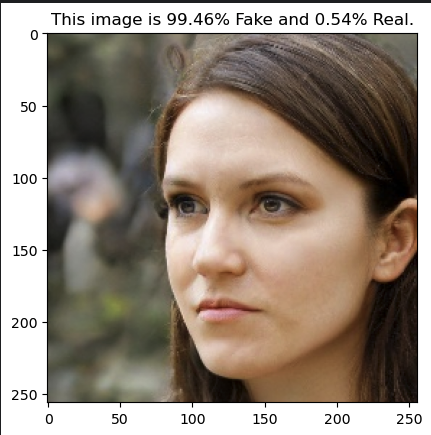

The project will include also the **Grad-cam** visualization to understand why a deep learning network makes its classification decisions.

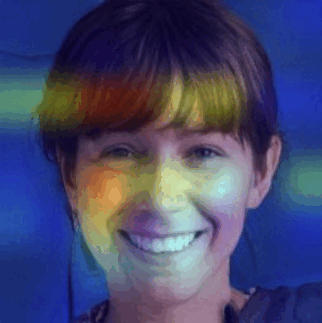

### Main Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics

In [ ]:
tf.keras.backend.clear_session() #clean session

## Data Loading

The paths to the training, validation, and test sets have been specified below.

In [ ]:
main_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

As we can see, each directory contains two subfolders: fake and real.

In [ ]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(valid_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

# Short EDA - Exploratory Data Analysis

Create a dictionary with three keys:
* **folder**: train, validation and test folders
* **image_path**: path of the images
* **label**: image's label (fake or real)    

In [ ]:
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [ ]:
images_df = pd.DataFrame(images_df)

In [ ]:
images_df

### Labels distribution

In [ ]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

In [ ]:
real_grouped_df.size()

In [ ]:
fake_grouped_df.size()

As we can see fromt the results, the labels are equally distributed on each folder.

## Data Preparation for visualization and training

## Data Augmentation

ImageDataGenerator generates batches of tensor image data with real-time data augmentation. Horizontal flip data augmentation is set to True in order to increase the size of a dataset by flipping images horizontally. This can help improve the accuracy of the model by exposing it to additional variations of the same images.

In [ ]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

Important! test_ds prediction and train_ds.classes (ground-truth) **will be not alligned** with suffle=True, so I need to disable shuffle for the test set.

In [ ]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False) #shuffle disabled

In [ ]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if label[i] == 0:
            plt.title("Fake")
        else:
            plt.title("Real")

## Data Visualization

In [ ]:
img,lbl = next(train_ds)
plot_images(img,lbl)


It's visible that all the value are scaled.

In [ ]:
for img, label in train_ds:
    print("Values: ", img[0])
    print("Label: ", label[0])
    break

Let's print the input shape:
- 32 is the batch size
- 256s are the pixel's values.
- 3 are the channel (rgb)

In [ ]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

In [ ]:
train_ds.class_indices

# CNN model architecture (DenseNet121)

In [ ]:
input_shape = (256, 256, 3) #define the input shape of our data

In [ ]:
#create the model's architecture and compile it
def get_model(input_shape):

    input = tf.keras.Input(shape=input_shape)

    densenet = tf.keras.applications.DenseNet121( weights="imagenet", include_top=False, input_tensor = input)

    x = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x) #binary classification

    model = tf.keras.Model(densenet.input, output)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model


In [ ]:
model_ft = get_model(input_shape)

# model_ft.summary()

In [ ]:
# tf.keras.utils.plot_model(model_ft, show_shapes=True)

Let's define the Callbacks

**ModelCheckpoint** callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
In this case, we don't have to worry about training for too long and overfitting the training set.

In [ ]:
checkpoint_filepath = "model_cp.weights.h5"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True)

The **EarlyStopping** callback stops training when a monitored metric (in this case val_loss) has stopped improving (in this case decreasing).

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=2,
                                                     restore_best_weights=True,
                                                    )

**ReduceOnPlateau** callback reduces learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

## Training

In [57]:
weights_file = '/kaggle/working/model_cp.weights.h5'

if os.path.exists(weights_file):
    print(f"Model weights file '{weights_file}' exists. Loading the model weights.")
    model = get_model(input_shape)
    model.load_weights(weights_file)
    weights_available = True
else : 
    print(f"Model weights file '{weights_file}' does not exist. Training the model.")
    history_ft = model_ft.fit(train_ds,
                       epochs = 10,
                       validation_data = valid_ds,
                       callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr])
    weights_available = False



# Freeze all layers except the last 20
num_layers = 5
for layer in model.layers[:-num_layers]:  # Exclude the last 20 layers
    layer.trainable = False

# Recompile the model (necessary after changing trainable status)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train or fine-tune the model
if not weights_available:
    print("Training the model from scratch.")
    history = model.fit(
        train_ds,
        epochs=5,
        validation_data=valid_ds,
        callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr]
    )
else:
    print(f"Fine-tuning the last {num_layers} layers.")
    history = model.fit(
        train_ds,
        epochs=5,
        validation_data=valid_ds,
        callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr]
    )

Model weights file '/kaggle/working/model_cp.weights.h5' exists. Loading the model weights.
Fine-tuning the last '5' layers.
Epoch 1/5
 512/1563 ━━━━━━━━━━━━━━━━━━━━ 9:09 523ms/step - accuracy: 0.9579 - loss: 0.0000e+00

KeyboardInterrupt: 

## Results

In [ ]:
if not weights_available: 
    plt.plot(history_ft.history['accuracy'])
    plt.plot(history_ft.history['val_accuracy'])
    plt.title('Model Accuracy (training & valid)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.show()
    
    
    plt.plot(history_ft.history['loss'])
    plt.plot(history_ft.history['val_loss'])
    plt.title('Model Loss (training & val)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.show()

The model is clearly overfitted. So wee have to restore the model weights from the ModelCheckpoint callback.

Let's try to evaluate the full overfitted model. We can see that it has a poor performance.

In [ ]:
# Evaluate the model on the test set
if not weights_available :
    test_loss, test_acc = model_ft.evaluate(test_ds)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_acc)

Here a ModelCheckpoint callback is necessary. Indeed loading the best weights results in a much better performance on the test set.

In [ ]:
if not weights_available :
    model = get_model(input_shape)
    
    # Restore the weights
    model.load_weights('/kaggle/working/model_cp.weights.h5')


In [ ]:
# Evaluate the model on the test set
if not weights_available :
    test_loss, test_acc = model.evaluate(test_ds)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_acc)

### Image example - Qualitative results

Let's try the model on a real image. It is very confident (99.96%) that it is a real one.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Text(0.5, 1.0, 'This image is 0.00% Fake and 100.00% Real.')

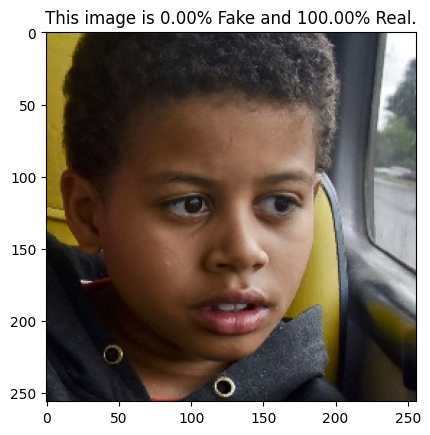

In [71]:
#real example
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00343.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")


The result score is near 1 if the image is **real** and 0 if the image is **fake**.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Text(0.5, 1.0, 'This image is 100.00% Fake and 0.00% Real.')

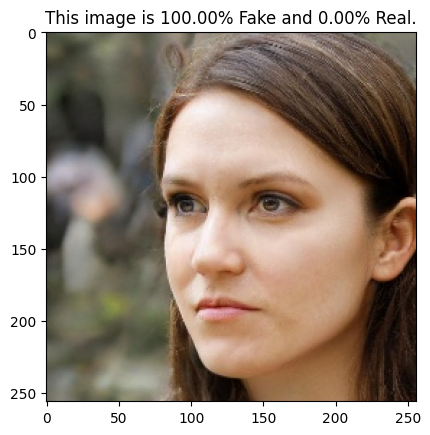

In [59]:
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00V5CZZSSO.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)

#fake example
test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

## Quantitative results

### Predictions

In [60]:
predicted_labels = model.predict(test_ds)

114/313 ━━━━━━━━━━━━━━━━━━━━ 42s 211ms/step

KeyboardInterrupt: 

In [ ]:
true_labels = test_ds.classes

### Confusion matrix

In [ ]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()

In [ ]:
metrics.accuracy_score(true_labels, predicted_labels.round())

### Roc curve

In [ ]:
fpr, tpr, _ = metrics.roc_curve(true_labels,  predicted_labels)
auc = metrics.roc_auc_score(true_labels, predicted_labels)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# eXaiplanable AI
## Grad-cam 
### class activation visualization

This example shows how to use the gradient-weighted class activation mapping (Grad-CAM) technique to understand why a deep learning network makes its classification decisions. Grad-CAM, invented by Selvaraju and coauthors, uses the gradient of the classification score with respect to the convolutional features determined by the network in order to understand which parts of the image are most important for classification.

Lot of the following code is from https://keras.io/examples/vision/grad_cam/

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import keras

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

## guided_gradcam

In [ ]:
def guided_relu(x):
    return tf.where(x > 0, x, 0)

def make_guided_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Watch the last conv layer output
        last_conv_layer_output, preds = grad_model(img_array)
        # Apply guided ReLU to the last conv layer output
        guided_last_conv_layer_output = guided_relu(last_conv_layer_output)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Guided Grad-CAM: Apply guided ReLU to the gradients
    guided_grads = tf.cast(grads > 0, "float32") * tf.cast(last_conv_layer_output > 0, "float32") * grads

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(guided_grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

## grad cam ++ 


In [ ]:
import tensorflow as tf
import numpy as np

def make_gradcampp_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape(persistent=True) as tape1:
        with tf.GradientTape() as tape2:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        # First gradient
        grads = tape2.gradient(class_channel, last_conv_layer_output)

    # Second gradient
    grads2 = tape1.gradient(grads, last_conv_layer_output)

    # Third gradient
    grads3 = tape1.gradient(grads2, last_conv_layer_output)

    # Compute Grad-CAM++
    numerator = grads ** 2 + grads2 * last_conv_layer_output
    denominator = 2 * grads ** 2 + grads2 ** 2 * last_conv_layer_output + 1e-7  # Add a small constant for numerical stability

    alpha = numerator / denominator
    relu_grads = tf.nn.relu(grads)
    alpha_relu_grads = alpha * relu_grads

    # Pool the gradients spatially
    pooled_grads = tf.reduce_mean(alpha_relu_grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# Get the names of all layers in the model.
#for idx in range(len(model.layers)):
#  print(model.get_layer(index = idx).name)

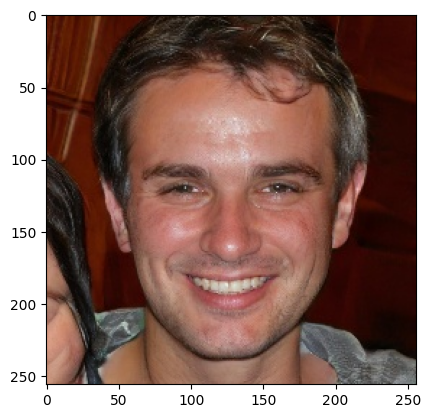

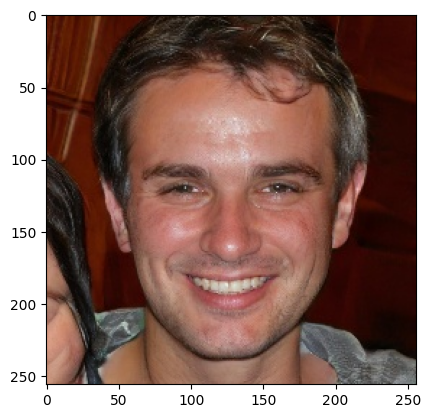

In [74]:
img_size = (256, 256)
last_conv_layer_name = "conv5_block16_1_conv"

img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/008BYSE725.jpg'

test_image = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256, 3))
plt.imshow(test_image)

img = tf.keras.preprocessing.image.img_to_array(test_image)
img = np.expand_dims(img, axis=0)
img = img/255.


###  Predict and show heatmap

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted: [[0.9707708]]


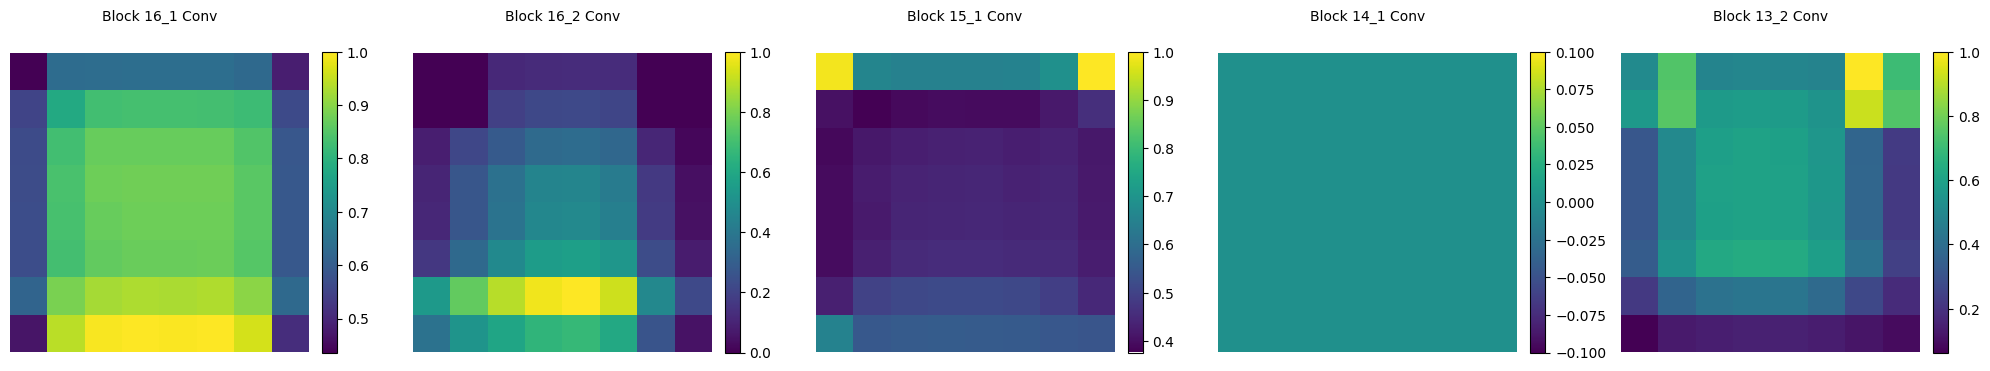

In [75]:
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img)
print("Predicted:", preds)

import matplotlib.pyplot as plt

# Generate class activation heatmaps
heatmap_1 = make_guided_gradcam_heatmap(img, model, "conv5_block16_1_conv")
heatmap_2 = make_gradcam_heatmap(img, model, "conv5_block16_2_conv")
heatmap_3 = make_gradcam_heatmap(img, model, "conv5_block15_1_conv")
heatmap_4 = make_gradcam_heatmap(img, model, "conv5_block14_1_conv")
heatmap_5 = make_gradcam_heatmap(img, model, "conv5_block13_2_conv")

# Create a figure with subplots (1 row, 5 columns)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust figsize as needed
heatmaps = [heatmap_1, heatmap_2, heatmap_3, heatmap_4, heatmap_5]
titles = [
    "Block 16_1 Conv",
    "Block 16_2 Conv",
    "Block 15_1 Conv",
    "Block 14_1 Conv",
    "Block 13_2 Conv",
]

# Plot each heatmap in a subplot
for i, ax in enumerate(axes):
    im = ax.matshow(heatmaps[i], cmap='viridis')
    ax.set_title(titles[i], fontsize=10)
    ax.axis('off')  # Hide axis for cleaner visualization
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Add colorbar

# Adjust layout and display
plt.tight_layout()
plt.show()


### Grad-CAM Explains Why

In [76]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    # superimposed_img.save(cam_path)

    # Display Grad CAM
    return (superimposed_img)

The Grad-CAM technique utilizes the gradients of the classification score with respect to the final convolutional feature map, to identify the parts of an input image that most impact the classification score. The places where this gradient is large are exactly the places where the final score depends most on the data.

The gradCAM function computes the importance map by taking the derivative of the reduction layer output for a given class with respect to a convolutional feature map. For classification tasks, the gradCAM function automatically selects suitable layers to compute the importance map for. You can also specify the layers with the 'ReductionLayer' and 'FeatureLayer' name-value arguments.

 The 'jet' colormap has deep blue as the lowest value and deep red as the highest.

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


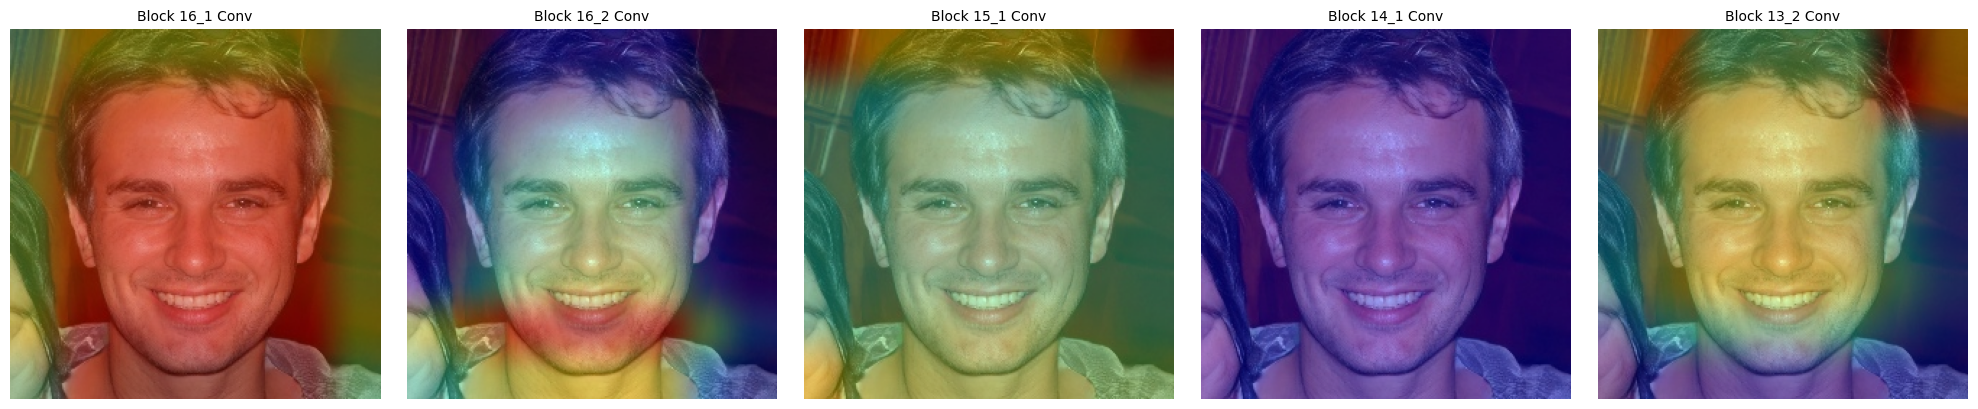

In [77]:
import matplotlib.pyplot as plt

# Collect Grad-CAM images into a list
gradcam_images = [
    save_and_display_gradcam(img_path, heatmap_1),
    save_and_display_gradcam(img_path, heatmap_2),
    save_and_display_gradcam(img_path, heatmap_3),
    save_and_display_gradcam(img_path, heatmap_4),
    save_and_display_gradcam(img_path, heatmap_5),
]

titles = [
    "Block 16_1 Conv",
    "Block 16_2 Conv",
    "Block 15_1 Conv",
    "Block 14_1 Conv",
    "Block 13_2 Conv",
]

# Create a figure with subplots (1 row, 5 columns)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust size as needed

# Plot Grad-CAM images
for i, ax in enumerate(axes):
    ax.imshow(gradcam_images[i])  # Display each Grad-CAM image
    ax.set_title(titles[i], fontsize=10)  # Set titles
    ax.axis('off')  # Turn off axes for cleaner look

# Adjust layout and display
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


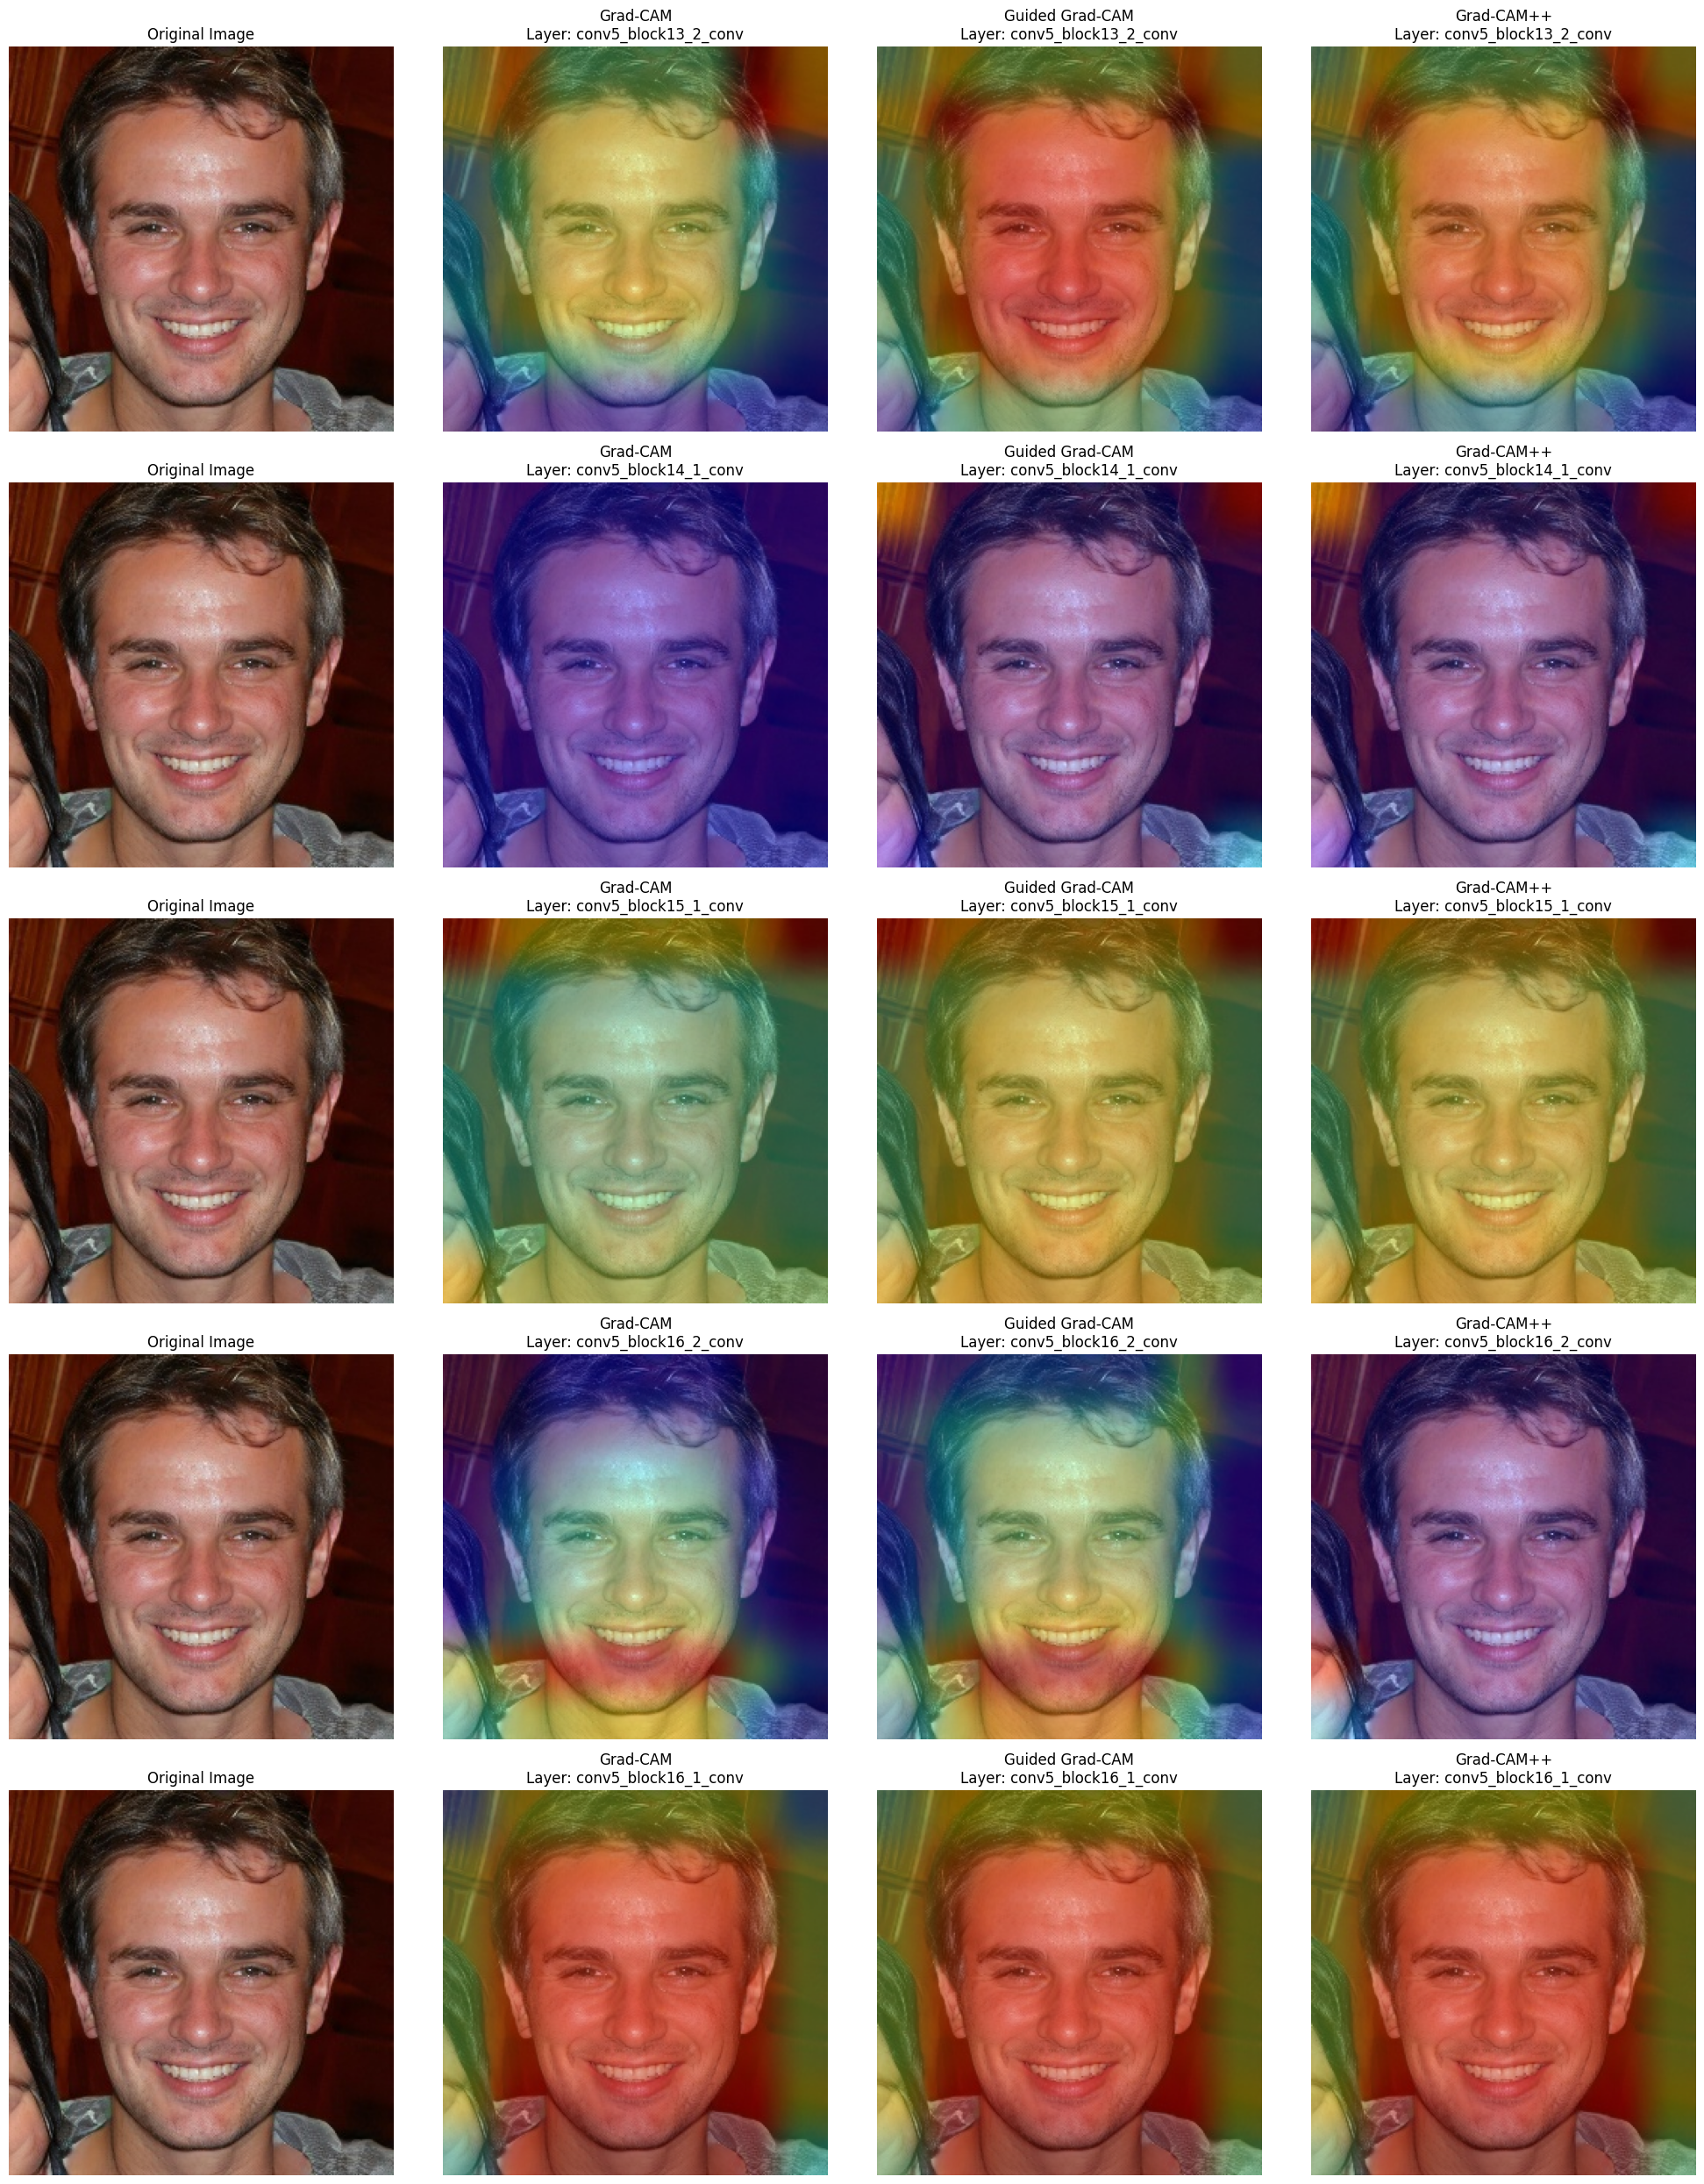

In [78]:

def plot_multiple_gradcams_for_layers(img, img_path, model, layer_names, pred_index=None, alpha=0.5):

    # Get predictions
    preds = model.predict(img)

    # Number of layers to visualize
    num_layers = len(layer_names)
    
    # Create a figure to display the images
    fig, axes = plt.subplots(num_layers, 4, figsize=(20, 5 * num_layers))
    
    # Load the original image
    original_img = keras.utils.load_img(img_path)
    original_img = keras.utils.img_to_array(original_img)
    
    for i, layer_name in enumerate(layer_names):
        # Generate heatmaps
        heatmap_gradcam = make_gradcam_heatmap(img, model, layer_name, pred_index)
        heatmap_guided_gradcam = make_guided_gradcam_heatmap(img, model, layer_name, pred_index)
        heatmap_gradcampp = make_gradcampp_heatmap(img, model, layer_name, pred_index)

        # Superimpose heatmaps on the original image
        superimposed_gradcam = save_and_display_gradcam(img_path, heatmap_gradcam, cam_path=None, alpha=alpha)
        superimposed_guided_gradcam = save_and_display_gradcam(img_path, heatmap_guided_gradcam, cam_path=None, alpha=alpha)
        superimposed_gradcampp = save_and_display_gradcam(img_path, heatmap_gradcampp, cam_path=None, alpha=alpha)

        # Display the original image
        axes[i, 0].imshow(original_img.astype('uint8'))
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Display Grad-CAM
        axes[i, 1].imshow(superimposed_gradcam)
        axes[i, 1].set_title(f'Grad-CAM\nLayer: {layer_name}')
        axes[i, 1].axis('off')
        
        # Display Guided Grad-CAM
        axes[i, 2].imshow(superimposed_guided_gradcam)
        axes[i, 2].set_title(f'Guided Grad-CAM\nLayer: {layer_name}')
        axes[i, 2].axis('off')
        
        # Display Grad-CAM++
        axes[i, 3].imshow(superimposed_gradcampp)
        axes[i, 3].set_title(f'Grad-CAM++\nLayer: {layer_name}')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

layer_names = ["conv5_block16_1_conv", "conv5_block16_2_conv", "conv5_block15_1_conv","conv5_block14_1_conv","conv5_block13_2_conv"]  # Example layer names

plot_multiple_gradcams_for_layers(img, img_path, model, list(reversed(layer_names)))

## select image

In [ ]:
# Select a sample image from the validation dataset

true_label = 1 
while true_label == 1 : 
    sample_batch, true_labels = next(valid_ds)
    sample_image = sample_batch[0:1]  # Take the first image for explanation
    true_label = true_labels[0]

pred_img = model.predict(sample_image)
print("pred accuracy ", pred_img)

## Overlay XAI Function

In [ ]:
def overlay_XAI(sample_image, grid, alpha=0.3, cmap='viridis',title="Integrated Gradients"):
    """
    Overlay the Integrated Gradients grid on the original image.

    Parameters:
    - grid (numpy.ndarray): The Integrated Gradients grid.
    - image (numpy.ndarray): The original image.
    - alpha (float): The transparency level of the overlay (0 to 1).
    - cmap (str): The colormap to use for the heatmap.

    Returns:
    - numpy.ndarray: The overlaid image.
    """
    
    # Normalize the grid to a range suitable for visualization
    grid_normalized = np.abs(grid)  # Use absolute values for visualization
    grid_normalized = (grid_normalized - np.min(grid_normalized)) / (np.max(grid_normalized) - np.min(grid_normalized))

    # Create a colormap for the overlay
    cmap = plt.get_cmap(cmap)
    heatmap = cmap(grid_normalized)

    # Convert image to RGB if it's grayscale
    if sample_image.shape[-1] == 1:
        image_rgb = plt.cm.gray(image[:, :, 0])[:, :, :3]
    else:
        image_rgb = sample_image

    # Blend the original image and heatmap
    overlay = (image_rgb * (1 - alpha) + heatmap[:, :, :3] * alpha)

        # Optionally, display the image and the explanation
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"True Label: {'Fake' if true_label == 0 else 'True'}")
    plt.subplot(1, 3, 1)
    plt.imshow(sample_image[0])
    plt.title(f"Prediction: {100 * (1 - pred_img[0][0]):.5f}% Fake and {100 * pred_img[0][0]:.5f}% Real.")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(grid, cmap='viridis')
    plt.title(title)
    plt.axis('off')
    


    # Display the overlaid image
    plt.subplot(1, 3, 3)
    plt.imshow(overlay[0])
    plt.title("Overlayed "+title)
    plt.axis('off')
    plt.show()
    return overlay


## Integrated Gradients
Integrated Gradients is a **model-agnostic method** for interpreting the predictions of any differentiable model. It provides a way to attribute the prediction of a model to its input features by approximating the integral of the gradients of the output with respect to the input along a straight path from a baseline instance to the input instance.

In [ ]:
!pip install tf-explain

In [ ]:
##### Import necessary libraries
from tf_explain.core.integrated_gradients import IntegratedGradients

import numpy as np
import matplotlib.pyplot as plt

# Create an instance of the IntegratedGradients explainer
explainer = IntegratedGradients()

# Explain the prediction for the selected image
grid = explainer.explain(
    (sample_image, true_label),  # Input data and true label
    model,                       # The trained model
    class_index=0,               # The class index to explain (e.g., the predicted class)
)


img = overlay_XAI(sample_image, grid, title="Integrated Gradients")

## Grad CAM 

In [ ]:
from tf_explain.core.grad_cam import GradCAM

grad_cam_explainer = GradCAM()

grad_cam_grid = grad_cam_explainer.explain(
        (sample_image, true_label),  # Input data and true label
        model,                       # The trained model
        class_index=0,               # The class index to explain (e.g., the predicted class)
        layer_name='conv5_block16_2_conv',       # Specify the layer name for Grad-CAM
    )


# Ensure grad_cam_grid is a 2D array for visualization
grad_cam_grid = grad_cam_grid[..., 0]

overlay_XAI(sample_image, grad_cam_grid, title="Grad-CAM")

## OcclusionSensitivity

In [ ]:
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

occlusion_explainer = OcclusionSensitivity()

occlusion_grid = occlusion_explainer.explain(
        (sample_image, true_label),  # Input data and true label
        model,                       # The trained model
        class_index=0,               # The class index to explain (e.g., the predicted class)
        patch_size=6,                # Size of the occlusion patch
    )



# Ensure grad_cam_grid is a 2D array for visualization
occlusion_grid = occlusion_grid[..., 0]
        
# Visualize occlusion_grid
overlay_XAI(sample_image, occlusion_grid, title="Occlusion Sensitivity")


## VanillaGradients

In [ ]:
##### Import necessary libraries
from tf_explain.core.vanilla_gradients import VanillaGradients

import numpy as np
import matplotlib.pyplot as plt

# Create an instance of the IntegratedGradients explainer
explainer = VanillaGradients()



# Explain the prediction for the selected image
grid = explainer.explain(
    (sample_image, true_label),  # Input data and true label
    model,                       # The trained model
    class_index=0,               # The class index to explain (e.g., the predicted class)
)


img = overlay_XAI(sample_image, grid, title="Vanilla Gradients")

## LIME

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Ensure the input image has the correct dimensions
if sample_image.ndim == 4:  # Check if batch dimension exists
    sample_image_dim = sample_image[0]  # Remove the batch dimension

# Verify the image shape
print(f"Processed sample image shape: {sample_image_dim.shape}")  # Should be (height, width, channels)

# Initialize the explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction for a single image
explanation = explainer.explain_instance(
    image=sample_image_dim,  # Input image with shape (height, width, channels)
    classifier_fn=lambda x: model.predict(x),  # Model prediction function
    top_labels=1,
    hide_color=0
)

# Get the explanation mask and overlay it on the original image
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=True
)

# Normalize the image for better visualization
overlay_image = temp / 255.0  # Assuming `temp` is in the range [0, 255]

# Plot the overlay with boundaries
overlay_XAI(sample_image, mask,title="LIME Explanation Overlay")

plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(overlay_image, mask))
plt.title("LIME Explanation Overlay")
plt.axis('off')
plt.show()


## SHAP SHapley Additive exPlanations

SHAP is a powerful framework for explaining the predictions of machine learning models. It leverages concepts from cooperative game theory to assign each feature a contribution value that explains its impact on the model's output.

In image classification, SHAP generates visual explanations by attributing pixel-level importance, helping us understand how specific regions of the input influence the model's decision. This is achieved by perturbing the input and observing changes in the model's predictions.

Key advantages of SHAP:

    - Model-Agnostic: Works with any machine learning model.
    - Interpretability: Provides intuitive, human-understandable explanations.
    - Local Explanations: Focuses on individual predictions for detailed analysis.

In [ ]:
import tensorflow as tf
import shap
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Assuming sample_image is your input image
# Ensure the input image has the correct dimensions
if sample_image.ndim == 4:  # Check if batch dimension exists
    sample_image_dim = sample_image[0]  # Remove the batch dimension
else:
    sample_image_dim = sample_image

# Verify the image shape
print(f"Processed sample image shape: {sample_image_dim.shape}")  # Should be (height, width, channels)

# Convert the sample image to uint8 format
sample_image_uint8 = (sample_image_dim * 255).astype(np.uint8)

# Place both the model and input on the same device (CPU or GPU)
with tf.device('/CPU:0'):  # Change to '/GPU:0' if needed
    # Update the SHAP masker with the corrected shape
    masker = shap.maskers.Image("inpaint_telea", sample_image_dim.shape)

    # Create a SHAP explainer
    explainer = shap.Explainer(model, masker)

    # Compute SHAP values for the input image
    shap_values = explainer(
        np.expand_dims(sample_image_uint8, axis=0),  # Add batch dimension
        max_evals=500,  # Number of model evaluations
        batch_size=50   # Batch size for SHAP computations
    )

shap.summary_plot(shap_values, sample_image_uint8)